Links:
1. https://minimaxir.com/2017/06/reddit-deep-learning/ 
2. https://www.freecodecamp.org/news/how-to-predict-likes-and-shares-based-on-your-articles-title-using-machine-learning-47f98f0612ea/
3. https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-4-count-vectorizer-b3f4944e51b5

Notes: need more feature engineering (scrape or add data), also need to clean data for special characters, etc...

Problems: dealing with text data, model doesn't really work

- more features, diff models
- split followers/time into diff categories
- look at word2vec and word embedding noteboooks
- title
- bin the claps - then change everything to classifications - make sure to look at class differences (bc what if 80% is in bin 1)
- confusion matrix
- how many claps would make you money

In [12]:
import matplotlib.pyplot as plt

In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [97]:
tech = pd.read_csv(r"C:\Users\Jenna\Documents\medium-tech-data.csv")
politics = pd.read_csv(r"C:\Users\Jenna\Documents\politics.csv")
money = pd.read_csv(r"C:\Users\Jenna\Documents\money.csv")
sports = pd.read_csv(r"C:\Users\Jenna\Documents\sports.csv")

In [98]:
tech = tech.drop(tech.columns[[0, 10, 11]], axis = 1) #drop null columns
tech = tech.drop(['url', 'username'], axis = 1) #drop unused columns (for now)

tech = tech[~(tech.text == '[]')]
tech = tech.dropna() #drop null rows

politics = politics[~(politics.text == '[]')]
politics = politics.dropna() #drop null rows

money = money[~(money.text == '[]')]
money = money.dropna() #drop null rows

In [99]:
sports.claps

0         16
1         84
2          0
3        150
4       1.1K
        ... 
2206     241
2207      50
2208     408
2209       0
2210       0
Name: claps, Length: 2211, dtype: object

### Visual

In [100]:
# cleaning - making all claps into integer value

def convert_to_number(x):
    total_stars = 0
    if 'K' in x:
        if len(x) > 1:
            try:
                total_stars = float(x.replace('K', '')) * 1000 # convert k to a thousand
            except:
                return None
    else:
        try:
            total_stars = int(x) # Less than 1000
        except ValueError:
            return None
    return int(total_stars)

tech['claps'] = tech['claps'].apply(convert_to_number)
tech = tech.dropna()
sports['claps'] = sports['claps'].apply(convert_to_number)
sports = sports.dropna()

In [101]:
tech = tech.loc[:, ['claps', 'text']]
politics = politics.loc[:,['claps', 'text']]
sports = sports.loc[:,['claps', 'text']]
money = money.loc[:,['claps', 'text']]


In [102]:
df = tech.append(politics, ignore_index = True)
df = df.append(sports, ignore_index = True)
df = df.append(money, ignore_index = True)

Text(0.5, 1.0, 'Claps in Medium Articles')

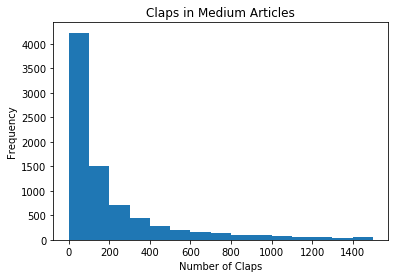

In [107]:
lst = []
for i in range(0, 1600, 100):
    lst.append(i)
    
    


plt.hist(df['claps'], bins = lst)
plt.xlabel('Number of Claps')
plt.ylabel('Frequency')
plt.title('Claps in Medium Articles')

        

In [116]:
df.describe()


,claps
count,8730.000000
mean,450.282818
std,1801.373541
min,0.000000
25%,33.000000
50%,105.000000
75%,319.750000
max,92000.000000


### Features

For simplicity purposes for now,
I will just look at the text column. Will add more later

(probably need to scrape/add more features such as follower data, etc.)


In [139]:

def conditions(x):
    if x <= 50:
        return '0-50'
    elif x <= 200:
        return '50-200'
    else:
        return '200+'
df['Range'] = df['claps'].apply(conditions)

In [140]:
X_train = df.text
Y_train = df['Range']

X_test = df.text
Y_test = df['Range']

In [141]:
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 50)
vector.fit(X_train)
train_transformed = vector.fit_transform(X_train)
test_transformed = vector.transform(X_test)
train_test_split(train_transformed, Y_train)[0], train_test_split(train_transformed, Y_train)[1]

(<6547x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 89331 stored elements in Compressed Sparse Row format>,
 <2183x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 30427 stored elements in Compressed Sparse Row format>)

In [142]:
from sklearn.linear_model import LogisticRegression

In [143]:
#create the model
logreg = LogisticRegression()


#fit the model with training data
logreg.fit(train_transformed, Y_train)

final_score = logreg.score(test_transformed, Y_test)

final_score

C:\Users\Jenna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jenna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.42668957617411224

In [144]:
predictions = logreg.predict(test_transformed)

In [187]:
from sklearn.metrics import confusion_matrix
def normed_cm(real, predictions):
    """Majority of code from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    to make a confusion matrix, given real labels and predicted labels"""
    
    #get the confusion matrix:
    cm = confusion_matrix(real, predictions)
    
    #normalized
    normed = []
    for row in np.arange(3):
         normed.append(cm[row]/sum(cm[row]))
    cm = np.array(normed)

    #axis and labels:
    fig, ax = plt.subplots()
    classes = ["0-50", "51-200", '200+']
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title="Confusion Matrix for Clap Classification",
               ylabel='True label',
               xlabel='Predicted label');
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [185]:
predictions

array(['0-50', '0-50', '50-200', ..., '50-200', '50-200', '50-200'],
      dtype=object)

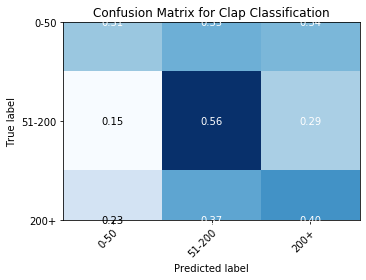

In [188]:
normed_cm(Y_test,predictions)